Installations

In [1]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [110]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, random_split
from torchvision import datasets, transforms, models
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import matplotlib.pyplot as plt
import cv2
import tempfile
import sys

from collections import Counter
from functools import partial
import logging
from concurrent.futures import ProcessPoolExecutor, as_completed
from typing import Optional, List, Sequence, Union
from PIL import Image
from tqdm import tqdm

from skimage.measure import label, regionprops
from scipy.ndimage import binary_fill_holes

import monai
from monai.transforms import Compose, LoadImage, ScaleIntensity, Resize, RandSpatialCrop, RandRotate90
import timm
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.transforms import Compose, Activations, AsDiscrete
from monai.visualize import plot_2d_or_3d_image
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    LoadImaged,
    RandRotate90d,
    RandSpatialCropd,
    ScaleIntensityd,
    Resized,
    EnsureChannelFirstd,
    Lambdad,

    RandFlipd,
    RandRotate90d,
    RandRotateD,
)

import time
import copy
import os
import shutil
import glob
from pathlib import Path

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Dataset

In [3]:
!unzip /content/drive/MyDrive/archaide.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Dr18/A10151/f_A10151_20191205_111414.jpg  
  inflating: __MACOSX/dataset/Dr18/A10151/._f_A10151_20191205_111414.jpg  
  inflating: dataset/Dr18/A10151/f_A10151_20191205_111401.jpg  
  inflating: __MACOSX/dataset/Dr18/A10151/._f_A10151_20191205_111401.jpg  
  inflating: dataset/Dr18/A10151/t_A10151_20191205_111223.jpg  
  inflating: __MACOSX/dataset/Dr18/A10151/._t_A10151_20191205_111223.jpg  
  inflating: dataset/Dr18/A10151/s_A10151_20191205_111232.jpg  
  inflating: __MACOSX/dataset/Dr18/A10151/._s_A10151_20191205_111232.jpg  
  inflating: dataset/Dr18/A10151/t_A10151_20191205_111154.jpg  
  inflating: __MACOSX/dataset/Dr18/A10151/._t_A10151_20191205_111154.jpg  
  inflating: dataset/Dr18/A10151/s_A10151_20191205_111148.jpg  
  inflating: __MACOSX/dataset/Dr18/A10151/._s_A10151_20191205_111148.jpg  
  inflating: dataset/Dr18/A10151/s_A10151_20191205_111228.jpg  
  inflating: __MACOSX/dataset/Dr18/A10151/._s_A1015

In [4]:
dataset_path = '/content/dataset/'
dataset_path = Path(dataset_path)

for class_folder in dataset_path.iterdir():
  if class_folder.is_dir():
    for sample_folder in class_folder.iterdir():
      if sample_folder.is_dir():
        for image_file in sample_folder.iterdir():
          if image_file.is_file() and image_file.suffix.lower() in ['.jpg', '.jpeg']:
            new_image_name = f"{sample_folder.name}_{image_file.name}"
            destination = class_folder / new_image_name

            counter=1
            while destination.exists():
              new_image_name = f"{sample_folder.name}_{image_file.stem}_{counter}{image_file.suffix}"
              destination = class_folder / new_image_name
              counter += 1

            shutil.move(str(image_file), str(destination))

        sample_folder.rmdir()

In [5]:
dataset_dir = '/content/dataset/'
masks_dir = '/content/mask'

os.makedirs('/content/data/image', exist_ok=True)
os.makedirs('/content/data/mask', exist_ok=True)

count = 0
for folder in glob.glob(f'{dataset_dir}/*'):
  list1 = glob.glob(f'{folder}/*.jpg')
  list1 = list(list1)
  print(f"directory {folder} has length {len(list1)}")

directory /content/dataset/Dr29 has length 623
directory /content/dataset/Dr24-25 has length 270
directory /content/dataset/Dr36 has length 511
directory /content/dataset/Dr35 has length 339
directory /content/dataset/Dr18 has length 1864
directory /content/dataset/Dr33 has length 418
directory /content/dataset/Dr38 has length 229
directory /content/dataset/Dr27 has length 841
directory /content/dataset/Dr37 has length 183


Creating masks

In [114]:
def load_image(image_path):
  image = cv2.imread(image_path)
  return image

def create_orange_mask(image, threshold_blue):
  threshold_blue = int(threshold_blue)
  threshold_blue = max(0, min(threshold_blue, 255))

  lower_orange = np.array([threshold_blue, 100, 100], dtype=image.dtype)
  upper_orange = np.array([255, 255, 255], dtype=image.dtype)

  mask = cv2.inRange(image, lower_orange, upper_orange)
  return mask

def extract_largest_region(mask):
  num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
  if num_labels <= 1:
    return mask
  largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
  largest_mask = (labels == largest_label).astype(np.uint8) * 255
  return largest_mask

def fill_mask_holes(mask):
  filled_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))
  return filled_mask

def process_image(image_path, image_save_dir, mask_save_dir, resize_dim=(224, 224)):
  image = load_image(image_path)
  image_resized = cv2.resize(image, dsize=resize_dim, interpolation=cv2.INTER_CUBIC)

  class_folder = os.path.basename(os.path.dirname(image_path))
  image_filename = os.path.basename(image_path)
  image_output_dir = os.path.join(image_save_dir, class_folder)
  os.makedirs(image_output_dir, exist_ok=True)
  image_output_path = os.path.join(image_output_dir, image_filename)
  cv2.imwrite(image_output_path, image_resized)

  threshold = np.percentile(image_resized, 15)
  mask = create_orange_mask(image_resized, threshold_blue=threshold)
  largest_mask = extract_largest_region(mask)
  filled_mask = fill_mask_holes(largest_mask).astype(np.uint8)
  # filled_mask = fill_mask_holes(largest_mask).astype(np.uint8) * 255

  filled_mask = ~filled_mask


  unique_values = np.unique(filled_mask)

  mask_output_dir = os.path.join(mask_save_dir, class_folder)
  os.makedirs(mask_output_dir, exist_ok=True)
  mask_output_path = os.path.join(mask_output_dir, image_filename)
  cv2.imwrite(mask_output_path, filled_mask)

  # return True

  return filled_mask, image_resized

In [115]:
imagedir = '/content/data/image'
maskdir = '/content/data/mask'

os.makedirs(imagedir, exist_ok=True)
os.makedirs(maskdir, exist_ok=True)

image_paths = []
for folder in glob.glob(os.path.join(dataset_dir, '*')):
  #HYPERPARAMETER: set to either 20 for testing, 400 for optimal operation, and 600 for 'nearly' unconstrianed operation.
  folder_images = glob.glob(os.path.join(folder, '*.jpg'))[:400]
  image_paths.extend(folder_images)

num_workers = min(32, os.cpu_count() + 4)
total_images = len(image_paths)

with ProcessPoolExecutor(max_workers=num_workers) as executor:
  process_func = partial(process_image, image_save_dir=imagedir, mask_save_dir=maskdir)
  futures = {executor.submit(process_func, img_path): img_path for img_path in image_paths}
  with tqdm(total=total_images, desc="Processing Images", unit="image") as pbar:
    processed = 0
    successes = 0
    for future in as_completed(futures):
      img_path = futures[future]
      result = future.result()
      processed += 1
      if result:
        successes += 1
      pbar.update(1)
      pbar.set_postfix({"Successes": successes})

Processing Images: 100%|██████████| 3021/3021 [00:13<00:00, 230.37image/s, Successes=3021]


[  0 255]


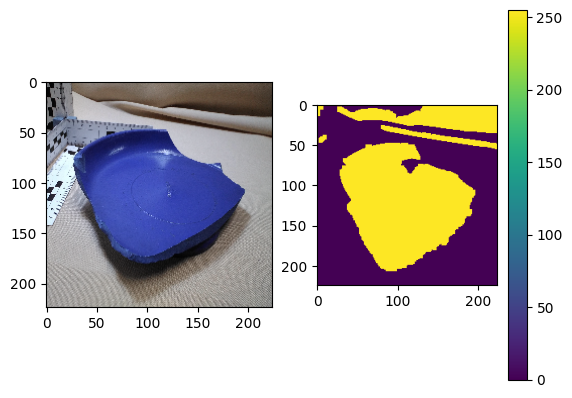

In [116]:
newimagedir = '/content/data2/newimage'
newmaskdir = '/content/data2/newmask'

os.makedirs(newimagedir, exist_ok=True)
os.makedirs(newmaskdir, exist_ok=True)


filled_mask, image_resized = process_image('/content/image2.png', newimagedir, newmaskdir)

print(np.unique(filled_mask))

fig, ax = plt.subplots(ncols=2, nrows=1)
ax[0].imshow(image_resized)
cbar = ax[1].imshow(filled_mask)
fig.colorbar(cbar)
plt.show()

UNet Model Architecture

In [117]:
class DecoderBlock(nn.Module):
  def __init__(self, in_channels: int, skip_channels: int, out_channels: int):
    super(DecoderBlock, self).__init__()
    self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
    self.conv1 = nn.Conv2d(out_channels + skip_channels, out_channels, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu1 = nn.ReLU(inplace=True)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.relu2 = nn.ReLU(inplace=True)

  def forward(self, x: torch.Tensor, skip: Optional[torch.Tensor]) -> torch.Tensor:
    x = self.up(x)
    if skip is not None:
      if x.size() != skip.size():
        x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)
      x = torch.cat([x, skip], dim=1)
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu2(x)
    return x

class UNetTimmWithClassification(nn.Module):
  def __init__(self,
      encoder_name: str = 'resnet34',
      encoder_weights: Optional[str] = 'imagenet',
      num_classes_seg: int = 1,
      num_classes_cls: int = 5
  ):

      super(UNetTimmWithClassification, self).__init__()

      self.encoder = timm.create_model(
          encoder_name,
          pretrained=(encoder_weights == 'imagenet'),
          features_only=True,
          in_chans=3
      )

      encoder_channels = self.encoder.feature_info.channels()
      decoder_channels = [2048, 1024, 512, 256]
      # decoder_channels = [512, 256, 128, 64]

      self.decoder4 = DecoderBlock(
          in_channels=decoder_channels[0],
          skip_channels=encoder_channels[3],
          out_channels=decoder_channels[1]
      )
      self.decoder3 = DecoderBlock(
          in_channels=decoder_channels[1],
          skip_channels=encoder_channels[2],
          out_channels=decoder_channels[2]
      )
      self.decoder2 = DecoderBlock(
          in_channels=decoder_channels[2],
          skip_channels=encoder_channels[1],
          out_channels=decoder_channels[3]
      )
      self.decoder1 = DecoderBlock(
          in_channels=decoder_channels[3],
          skip_channels=encoder_channels[0],
          out_channels=decoder_channels[3]
      )
      self.final_up = nn.ConvTranspose2d(
          in_channels=decoder_channels[-1],
          out_channels=32,
          kernel_size=2,
          stride=2
      )
      self.final_conv_seg = nn.Conv2d(
          in_channels=32,
          out_channels=num_classes_seg,
          kernel_size=1
      )

      #Cls head
      self.classification_head = nn.Sequential(
          nn.AdaptiveAvgPool2d(1),
          nn.Flatten(),
          nn.Linear(2048, 512),
          # nn.Linear(encoder_channels[-1], 512),
          nn.Dropout(0.2),
          nn.Linear(512, 512),
          nn.ReLU(),
          nn.Linear(512, num_classes_cls)
      )

      if num_classes_cls > 1:
          self.classification_activation = nn.Softmax(dim=1)
      elif num_classes_cls == 1:
          self.classification_activation = nn.Sigmoid()
      else:
          self.classification_activation = None

      if self.classification_activation is not None:
          self.classification_head.add_module("activation", self.classification_activation)

      #Xavier weight initialize
      if encoder_weights == 'xavier':
        self.apply(self.xavier_init_weights)

  def xavier_init_weights(self, m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
      nn.init.xavier_uniform_(m.weight)
      if m.bias is not None:
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
      nn.init.xavier_uniform_(m.weight)
      if m.bias is not None:
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d):
      nn.init.ones_(m.weight)
      nn.init.zeros_(m.bias)

  def forward(self, x: torch.Tensor) -> tuple:
    features = self.encoder(x)
    C0, C1, C2, C3, C4 = features
    cls = self.classification_head(C4)
    D4 = self.decoder4(C4, C3)
    D3 = self.decoder3(D4, C2)
    D2 = self.decoder2(D3, C1)
    D1 = self.decoder1(D2, C0)
    x = self.final_up(D1)
    seg = self.final_conv_seg(x)
    return seg, cls

Dataset class

In [118]:
class ImageSegDataset(Dataset):
  def __init__(self, images, segs, class_to_idx, transform=None):
    self.image_paths = images
    self.mask_paths = segs
    self.class_to_idx = class_to_idx
    self.transform = transform
  def __len__(self):
    return len(self.image_paths)
  def __getitem__(self, idx):
    image_filepath = self.image_paths[idx]
    mask_filepath = self.mask_paths[idx]
    data = {'image': image_filepath, 'mask': mask_filepath}

    if self.transform is not None:
      data = self.transform(data)
    image = data['image']
    mask = data['mask']

    class_name = os.path.basename(os.path.dirname(image_filepath))
    label = self.class_to_idx.get(class_name, -1)
    return image, mask, label

Class indexes

In [119]:
def get_class_mapping(dataset_directory):
  classes = [d.name for d in os.scandir(dataset_directory) if d.is_dir()]
  classes.sort()

  class_to_idx = {}
  for idx, cls_name in enumerate(classes):
    class_to_idx[cls_name] = idx

  return class_to_idx

Early stopping

In [120]:
def early_stopping(validation_loss, min_loss, counter, patience=3):
  if min_loss == np.inf:
    min_loss =validation_loss
  if (validation_loss) > min_loss:
      counter +=1
      if counter >= patience:
        return True
      return False
  else:
    min_loss = validation_loss
    counter = 0
    return False

Custom loss function

In [121]:
def loss_function(outputs, mask, label, alpha=0.5, beta=0.5):
  segmentation_output = outputs[0]
  classification_output = outputs[1]

  dice = DiceLoss(sigmoid=True)
  ce = nn.CrossEntropyLoss()

  diceloss = dice(segmentation_output, mask)
  celoss = ce(classification_output, label)

  total_loss = (alpha) * diceloss + (beta) * celoss
  return total_loss, diceloss, celoss

Transforms

In [122]:
images = sorted(glob.glob(os.path.join(imagedir, "*/*.jpg")))
segs = sorted(glob.glob(os.path.join(maskdir, "*/*.jpg")))
TARGET_SIZE = (224, 224)

train_transforms = Compose([
    LoadImaged(keys=["image", "mask"], image_only=False),
    EnsureChannelFirstd(keys=["image", "mask"]),
    ScaleIntensityd(keys=["image", "mask"]),
    Resized(spatial_size=TARGET_SIZE, keys=["image", "mask"], mode=["bilinear", "nearest"]),
    RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=0),
    RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=1),
    RandRotate90d(keys=["image", "mask"], prob=0.5, max_k=3),
    Lambdad(keys=["mask"], func=lambda x: x / 255.0),
    RandRotateD(keys=["image", "mask"], range_x=np.pi/4, prob=0.5),
])

val_transforms = Compose([
    LoadImaged(keys=["image", "mask"], image_only=False),
    EnsureChannelFirstd(keys=["image", "mask"]),
    Lambdad(keys=["mask"], func=lambda x: x / 255.0),
    ScaleIntensityd(keys=["image", "mask"]),
    Resized(spatial_size=TARGET_SIZE, keys=["image", "mask"], mode=["bilinear", "nearest"])
])

Hyperparameters

In [123]:
epoch_num = 5
patience=2
val_interval=2

alpha = 0.3
beta = 0.7

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)

data_dir = '/content/data/image'
class_to_idx = get_class_mapping(data_dir)

train_ds = ImageSegDataset(images, segs, class_to_idx, train_transforms)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())

val_ds = ImageSegDataset(images, segs, class_to_idx, val_transforms)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

model = UNetTimmWithClassification(encoder_name='resnet50', encoder_weights='imagenet', num_classes_seg=1,  num_classes_cls=9).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
writer = SummaryWriter()

labels = [label for _, _, label in train_ds]
class_counts = Counter(labels)

Weighted sampler

In [124]:
labels = [label for _, _, label in train_ds]
class_counts = Counter(labels)

num_samples = len(train_ds)
num_classes = len(class_to_idx)
class_weights = {cls: 0.0 for cls in range(num_classes)}
for cls in class_to_idx.values():
  class_count = class_counts.get(cls, 0)
  if class_count > 0:
    class_weights[cls] = 1.0 / class_count
  else:
    class_weights[cls] = 0.0

weights_per_class = torch.tensor([class_weights[cls] for cls in range(num_classes)])
sample_weights = torch.tensor([weights_per_class[label] for label in labels])
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=num_samples, replacement=True)

dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

Training loop

In [125]:
def train_one_epoch(epoch, model, train_loader, optimizer, loss_function, writer, device, alpha, beta):
  model.train()
  epoch_total_loss, epoch_dice_loss, epoch_ce_loss = 0, 0, 0
  for step, batch_data in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1} - Training"), start=1):
    images, segmentations, cls_labels = (batch_data[0].to(device), batch_data[1].to(device), batch_data[2].to(device))
    optimizer.zero_grad()
    outputs = model(images)
    total_loss, diceloss, celoss = loss_function(outputs, segmentations, cls_labels, alpha, beta)
    total_loss.backward()
    optimizer.step()

    epoch_total_loss += total_loss.item()
    epoch_dice_loss += diceloss.item()
    epoch_ce_loss += celoss.item()

    global_step = epoch * len(train_loader) + step
    writer.add_scalar("Train/Total_Loss", total_loss.item(), global_step)
    writer.add_scalar("Train/Dice_Loss", diceloss.item(), global_step)
    writer.add_scalar("Train/CE_Loss", celoss.item(), global_step)

  avg_train_total_loss = epoch_total_loss / len(train_loader)
  avg_train_dice_loss = epoch_dice_loss / len(train_loader)
  avg_train_ce_loss = epoch_ce_loss / len(train_loader)

  return avg_train_total_loss, avg_train_dice_loss, avg_train_ce_loss

In [126]:
def evaluation(epoch, model, val_loader, loss_function, dice_metric, post_trans, writer, device, alpha, beta):
  model.eval()
  val_total_loss, val_dice_loss, val_ce_loss = 0, 0, 0
  val_correct, val_total = 0, 0
  preds_list, labels_list = [], []

  with torch.no_grad():
    for step, val_data in enumerate(tqdm(val_loader, desc=f"Epoch {epoch + 1} - Validation"), start=1):
      val_images, val_segmentations, val_cls_labels = (val_data[0].to(device), val_data[1].to(device), val_data[2].to(device))

      val_outputs = model(val_images)
      total_loss, diceloss, celoss = loss_function(val_outputs, val_segmentations, val_cls_labels, alpha, beta)

      val_total_loss += total_loss.item()
      val_dice_loss += diceloss.item()
      val_ce_loss += celoss.item()

      seg_output = post_trans(val_outputs[0])
      dice_metric(seg_output, val_segmentations)

      cls_output = val_outputs[1]
      _, preds = torch.max(cls_output, 1)
      val_correct += torch.sum(preds == val_cls_labels)
      val_total += val_cls_labels.size(0)

      preds_list.extend(preds.cpu().numpy())
      labels_list.extend(val_cls_labels.cpu().numpy())

    avg_val_total_loss = val_total_loss / len(val_loader)
    avg_val_dice_loss = val_dice_loss / len(val_loader)
    avg_val_ce_loss = val_ce_loss / len(val_loader)
    dice_score = dice_metric.aggregate().item()
    dice_metric.reset()
    accuracy = val_correct.double() / val_total

    print(f"validation total loss: {avg_val_total_loss}")

    return avg_val_total_loss, avg_val_dice_loss, avg_val_ce_loss, dice_score, accuracy, preds_list, labels_list

In [132]:
def train(model, train_loader, val_loader, optimizer, loss_function, dice_metric, post_trans, writer, device, epoch_num, val_interval, early_stopping, patience, alpha, beta):
  best_metric = -1
  best_metric_epoch = -1

  epoch_loss_values = []
  metric_values = []
  train_loss_values = []
  train_dice_loss_values = []
  train_ce_loss_values = []
  val_loss_values = []
  val_dice_loss_values = []
  val_ce_loss_values = []
  val_dice_scores = []
  val_accuracy_values = []

  min_loss = np.inf
  counter = 0

  best_epoch_preds = []
  best_epoch_labels = []

  for epoch in range (epoch_num):
    train_total_loss, train_dice_loss, train_ce_loss = train_one_epoch(epoch, model, train_loader, optimizer, loss_function, writer, device, alpha, beta)
    train_loss_values.append(train_total_loss)
    train_dice_loss_values.append(train_dice_loss)
    train_ce_loss_values.append(train_ce_loss)
    print(f'epoch num: {epoch + 1} training loss: {train_total_loss:.4f}, dice loss: {train_dice_loss:.4f}, cross entropy loss: {train_ce_loss:.4f}')

    if (epoch + 1) % val_interval == 0:
      val_total_loss, val_dice_loss, val_ce_loss, dice_score, accuracy, preds_list, labels_list = evaluation(epoch, model, val_loader, loss_function, dice_metric, post_trans, writer, device, alpha, beta)
      val_loss_values.append(val_total_loss)
      val_dice_loss_values.append(val_dice_loss)
      val_ce_loss_values.append(val_ce_loss)
      val_dice_scores.append(dice_score)
      val_accuracy_values.append(accuracy.item())
      print(f'dice score: {dice_score:.4f} accuracy: {accuracy:.4f}')

      if accuracy > best_metric:
        best_metric = accuracy
        best_metric_epoch = epoch + 1
        torch.save(model.state_dict(), "best_metric_model_segmentation2d_array.pth")
        best_epoch_preds = preds_list.copy()
        best_epoch_labels = labels_list.copy()

      if early_stopping(val_total_loss, min_loss, counter, patience=patience):
        print("early stopping triggered")
        break

  print(f"best accuracy total: {best_metric:.4f} for epoch number: {best_metric_epoch} and best dice total: {best_metric:.4f} for epoch number: {best_metric_epoch}")
  writer.close()

  train_epochs = range(1, epoch_num + 1)
  val_epochs = range(val_interval, epoch_num + 1, val_interval)

  plt.figure(figsize=(10, 6))
  plt.plot(train_epochs, train_ce_loss_values, label='Train CE Loss', color='blue')
  plt.plot(train_epochs, train_dice_loss_values, label='Train Dice Loss', color='red')
  plt.plot(val_epochs, val_ce_loss_values, label='Val CE Loss', color='green')
  plt.plot(val_epochs, val_dice_loss_values, label='Val Dice Loss', color='orange')
  plt.plot(val_epochs, val_dice_scores, label='Val Dice Score', color='brown')
  plt.plot(val_epochs, val_accuracy_values, label='Val Accuracy Score', color='salmon')

  plt.title('Training & Validation Loss Curves')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

  return best_metric, best_metric_epoch, best_epoch_preds, best_epoch_labels


Epoch 1 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.22it/s]


epoch num: 1 training loss: 1.5658, dice loss: 0.9923, cross entropy loss: 1.8117


Epoch 2 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.23it/s]


epoch num: 2 training loss: 1.4965, dice loss: 0.9922, cross entropy loss: 1.7126


Epoch 2 - Validation: 100%|██████████| 95/95 [00:08<00:00, 10.78it/s]


validation total loss: 1.2171972092829253
dice score: 0.8816 accuracy: 0.6892


Epoch 3 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.25it/s]


epoch num: 3 training loss: 1.4739, dice loss: 0.9922, cross entropy loss: 1.6803


Epoch 4 - Training: 100%|██████████| 24/24 [00:20<00:00,  1.19it/s]


epoch num: 4 training loss: 1.4598, dice loss: 0.9922, cross entropy loss: 1.6601


Epoch 4 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.45it/s]


validation total loss: 1.2232710298738982
dice score: 0.8008 accuracy: 0.7193


Epoch 5 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.25it/s]


epoch num: 5 training loss: 1.4567, dice loss: 0.9922, cross entropy loss: 1.6558
best accuracy total: 0.7193 for epoch number: 4 and best dice total: 0.7193 for epoch number: 4


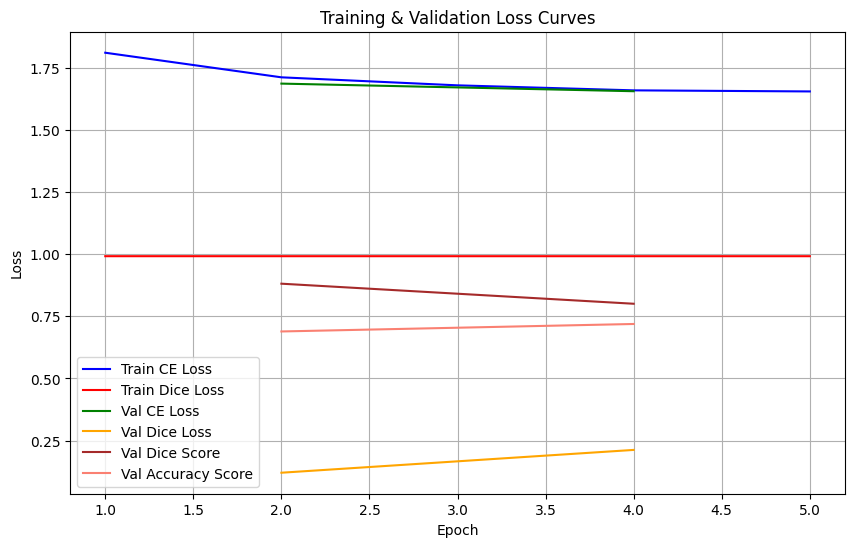

In [133]:
best_metric, best_metric_epoch, best_epoch_preds, best_epoch_labels = train(model, train_loader, val_loader, optimizer, loss_function, dice_metric, post_trans, writer, device, epoch_num, val_interval, early_stopping, patience, alpha, beta)

Visualization

for val_data in val_loader, we want val_segementation as the ground truth, which will be val_data[1]. Afterwards, to get the prediction, we can just use the functions that we defined above to get it. Afterwards, we can plot it.

In [ ]:
for step, val_data in val_loader:
  val_images, val_segmentations, val_cls_labels = (val_data[0].to(device), val_data[1].to(device), val_data[2].to(device))

In [62]:
def visualization(model, val_loader, loss_function, dice_metric, post_trans, writer, device, alpha, beta):
  model.eval()
  val_total_loss, val_dice_loss, val_ce_loss = 0, 0, 0
  val_correct, val_total = 0, 0
  preds_list, labels_list = [], []

  with torch.no_grad():
    for val_data in val_loader:
      val_images, val_segmentations, val_cls_labels = (val_data[0].to(device), val_data[1].to(device), val_data[2].to(device))

      print("uqnie val segs, ", torch.unique(val_segmentations))

      seg, cls = model(val_images)

      print(torch.unique(seg))

      seg_output = post_trans(seg)
      print(torch.unique(seg_output))
      dice_metric(seg_output, val_segmentations)

      print(seg.shape)

      for pred, gt in zip(seg_output, val_segmentations):
        pred = pred.squeeze().cpu()
        gt = gt.squeeze().cpu()
        fig, ax = plt.subplots(ncols=2, nrows=1)
        ax[0].imshow(gt)
        ax[1].imshow(pred)

      break

uqnie val segs,  metatensor([0.0000, 0.5000, 1.0000], device='cuda:0')
metatensor([-21.4380, -21.3246, -21.2911,  ...,  21.8312,  21.9201,  22.2240],
       device='cuda:0')
metatensor([0., 1.], device='cuda:0')
torch.Size([32, 1, 224, 224])


<ipython-input-62-60f146375634>:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(ncols=2, nrows=1)


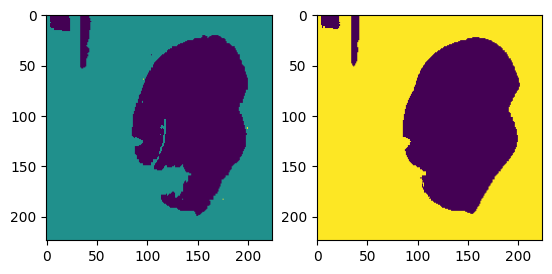

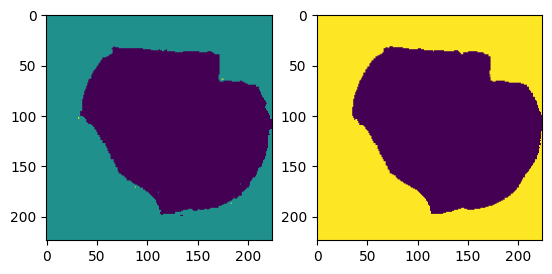

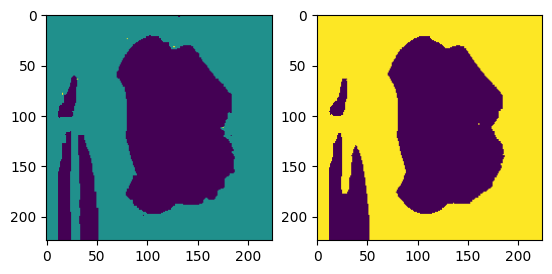

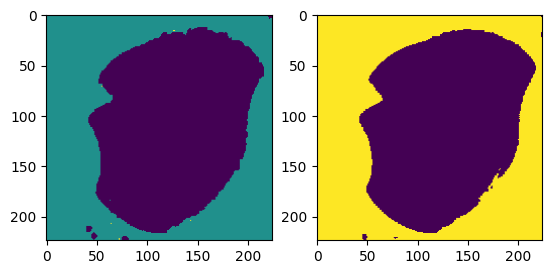

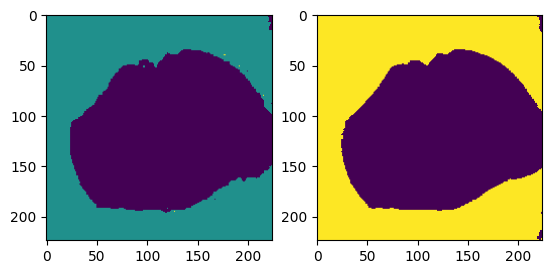

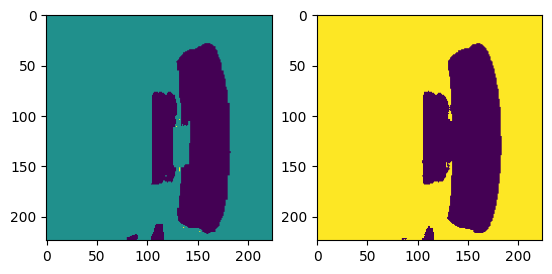

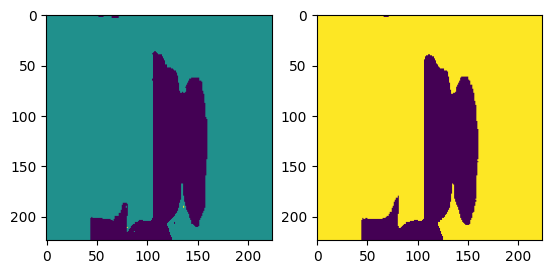

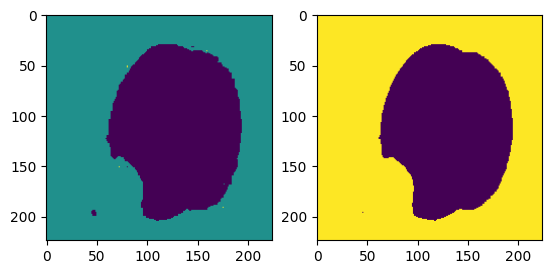

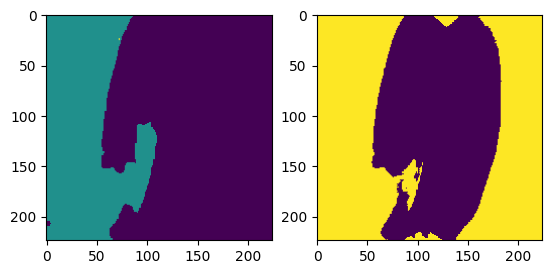

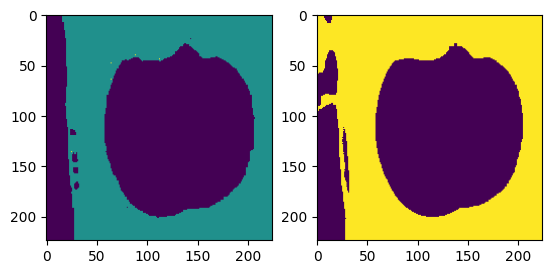

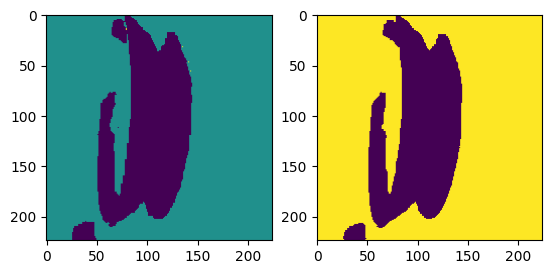

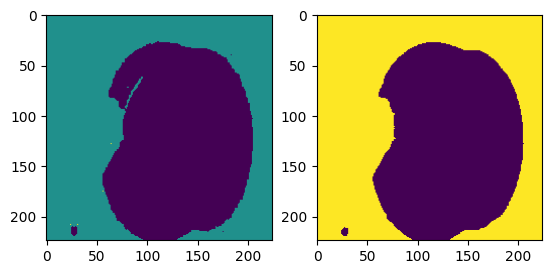

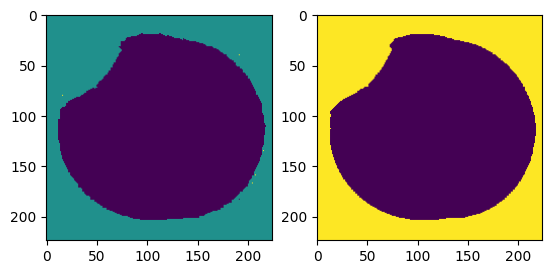

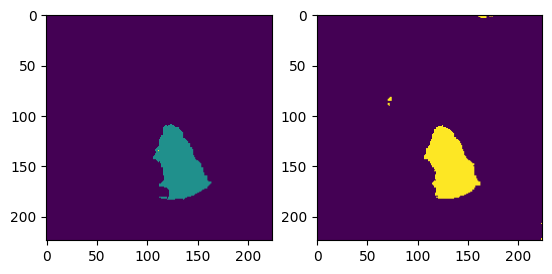

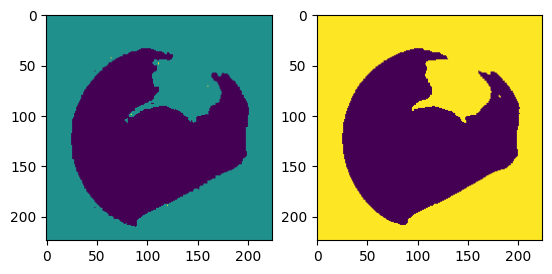

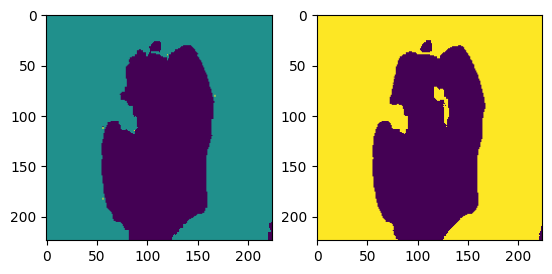

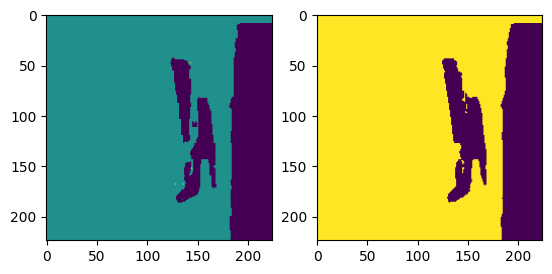

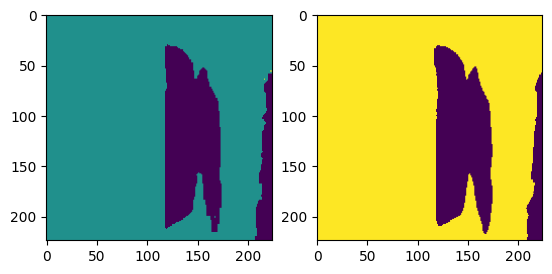

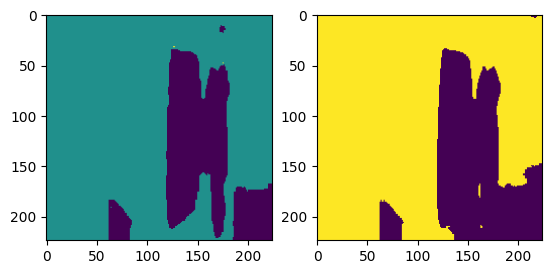

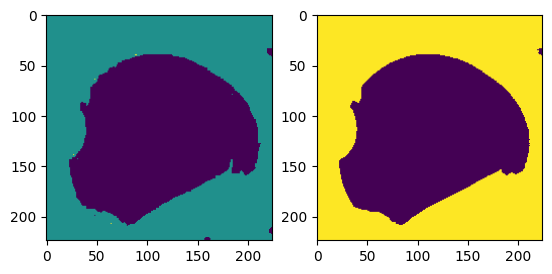

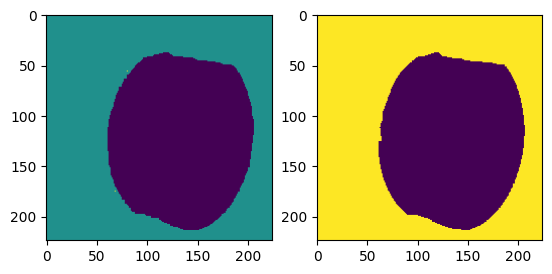

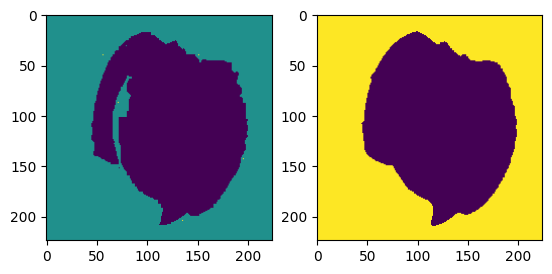

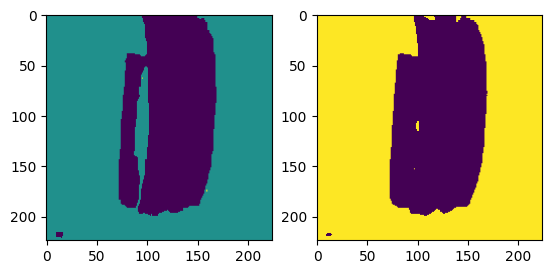

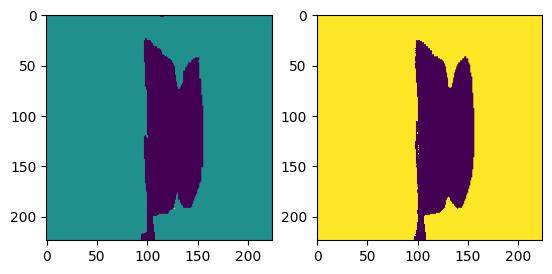

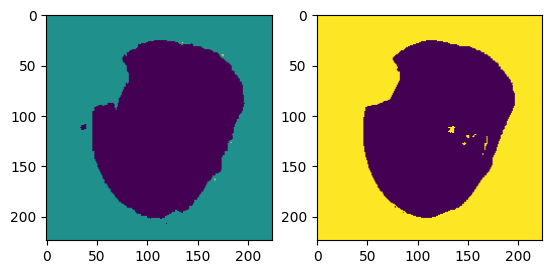

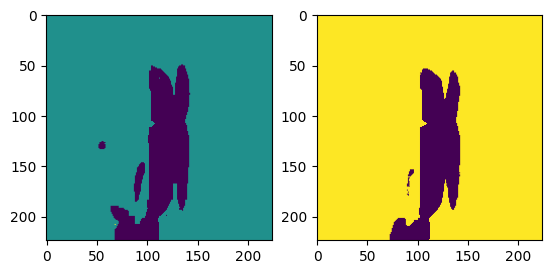

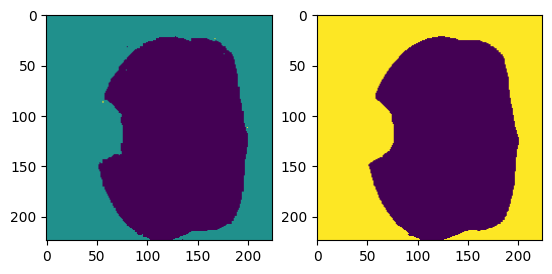

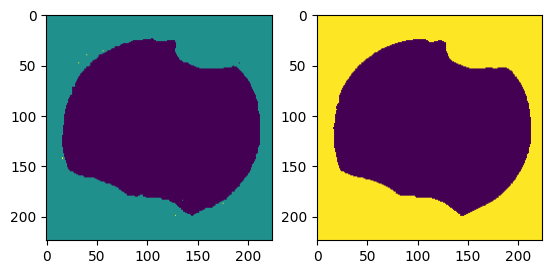

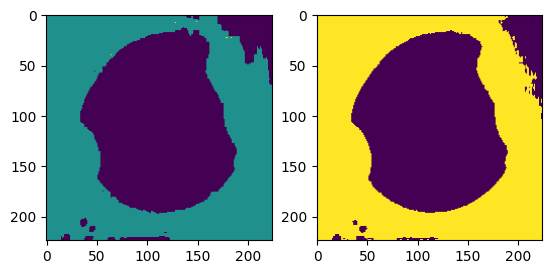

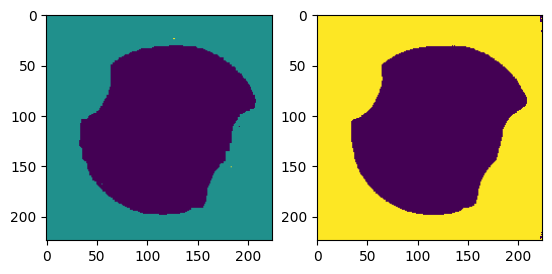

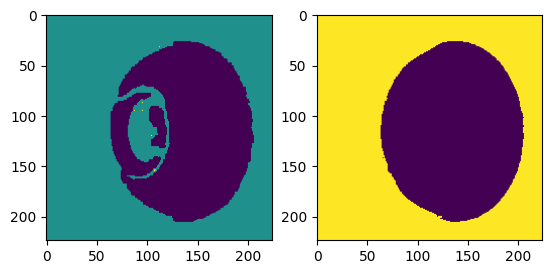

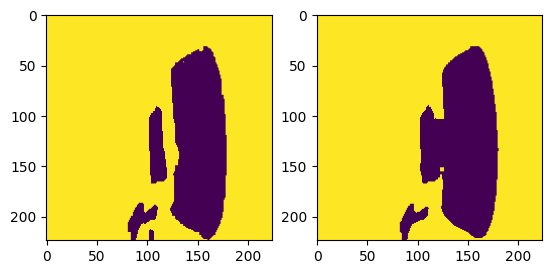

In [63]:
visualization(model, val_loader, loss_function, dice_metric, post_trans, writer, device, alpha, beta)